In [ ]:
!unzip /content/drive/MyDrive/Asian1.zip
!unzip /content/drive/MyDrive/European1.zip

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

class MakeDataset(Dataset): # Подготовка датасета

    def __init__(self, files, files1 = None, mode = None, mode_sample = None):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        self.len_ = len(self.files)
        self.mode = mode
        if self.mode == None:
            self.files1 = sorted(files1)
            self.len1_ = len(self.files1)
        self.mode_sample = mode_sample
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index % len(self.files)])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == None:
            if self.mode_sample == 'rand':
                y = self.load_sample(self.files1[random.randint(0, len(self.files1) - 1)])
            else:
                y = self.load_sample(self.files1[index % len(self.files)])
            y = self._prepare_sample(y)
            y = np.array(y / 255, dtype='float32')
            y = transform(y)

            return x, y
        else:
            return x
        
    def _prepare_sample(self, image):
        image = image.resize((224, 224))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False): # Функция вывода изображения

    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
train_as = Path('/content/Asian1')
train_eu = Path('/content/European1')

as_files = sorted(list(train_as.rglob('*.png')))
eu_files = sorted(list(train_eu.rglob('*.png')))

In [ ]:
asian = []
european = []

for filename in as_files:
  asian.append(str(filename))

for filename in eu_files:
  european.append(str(filename)) 

In [ ]:
len(european)

1637

In [ ]:
import torch

num = torch.randint(0, len(asian), ((len(european) - len(asian),))) 
for i in num:
  asian.append(asian[i])

In [ ]:
len(asian)

1637

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
     asian, european, test_size=0.01, random_state=42)

In [ ]:
train_dataset = MakeDataset(X_train, y_train)
test_dataset = MakeDataset(X_test, y_test, mode = None)

In [ ]:
#train_dataset = MakeDataset(asian, european)

1
0
0
1
0
1


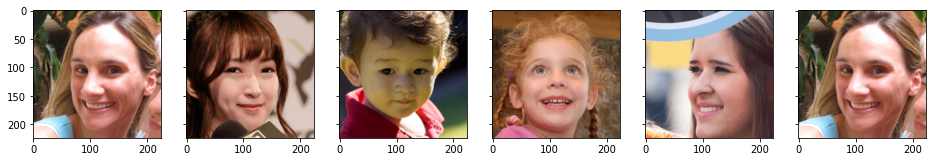

In [ ]:
import random
fig, ax = plt.subplots(nrows=1, ncols=6,figsize=(16, 16), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val = dataset[random_characters][0]
    imshow(im_val.data.cpu(), plt_ax=fig_x)
    print(dataset[random_characters][1])

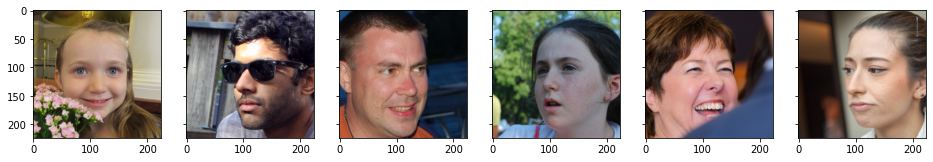

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=6,figsize=(16, 16), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,500))
    im_val = train_dataset[random_characters][1]
    imshow(im_val.data.cpu(), plt_ax=fig_x)

In [ ]:
dataset = []

for i in train_dataset:
  dataset.append((i[0], 0))
  dataset.append((i[1], 1))

In [ ]:
test_set = []


for i in test_dataset:
  test_set.append((i[0], 0))
  test_set.append((i[1], 1))

In [ ]:
len(test_set)

794

In [ ]:
n_classes = 2

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler = None):

    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        # print(labels)
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs).float()
        #outputs = torch.squeeze(outputs, -1).float()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # scheduler.step()
        preds = torch.argmax(outputs, 1).double()
        running_loss += loss.item() * inputs.size(0)
        print(labels)
        print(preds)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
        print(running_loss / processed_data)

              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs).float()
            #outputs = torch.squeeze(outputs, -1).float()
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1).double()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_dataset, val_dataset, model, epochs, batch_size, l_rate):
    
    

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr = l_rate)
        criterion = nn.CrossEntropyLoss()
        
        for epoch in range(epochs):
            
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
from torchvision.models import resnet34

model = resnet34(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
model = model.to(DEVICE)

for name, param in model.named_parameters():
  if("bn" not in name):
        param.requires_grad = False

model.fc = nn.Sequential(nn.Linear(model.fc.in_features, 512),
                                  nn.ReLU(),
                                  nn.Dropout(),
                                  nn.Linear(512, 2))

In [ ]:
history_last_layer = train(dataset, test_set, model=model, epochs=5, batch_size=64, l_rate = 10e-4)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
        1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,
        1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1])
tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0.,
        1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1.], dtype=torch.float64)
0.03153518959879875
tensor([1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0,
        0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
        1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0])
tensor([1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1.,
        0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 

epoch:  20%|██        | 1/5 [12:48<51:12, 768.18s/it]


Epoch 001 train_loss: 0.0549     val_loss 0.5624 train_acc 0.9865 val_acc 0.9421
tensor([1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1,
        1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0])
tensor([1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1.,
        0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1.,
        1., 1., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=torch.float64)
0.004220803268253803
tensor([0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,
        0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
        0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0])
tensor([0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0.,
        1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1

epoch:  40%|████      | 2/5 [25:36<38:24, 768.14s/it]


Epoch 002 train_loss: 0.0320     val_loss 0.5878 train_acc 0.9912 val_acc 0.9421
tensor([0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0])
tensor([0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0.,
        0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
        1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
        1., 0., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=torch.float64)
0.0032533311750739813
tensor([1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1])
tensor([1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1.,
        1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 

epoch:  60%|██████    | 3/5 [38:14<25:30, 765.27s/it]


Epoch 003 train_loss: 0.0208     val_loss 0.7522 train_acc 0.9945 val_acc 0.9131
tensor([0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
        0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0])
tensor([0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1.,
        1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1.,
        1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1.,
        1., 1., 0., 1., 0., 1., 1., 0., 0., 0.], dtype=torch.float64)
0.0606522411108017
tensor([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0])
tensor([0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
        1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.,

epoch:  80%|████████  | 4/5 [50:51<12:42, 762.58s/it]


Epoch 004 train_loss: 0.0098     val_loss 0.6486 train_acc 0.9975 val_acc 0.9421
tensor([0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
        1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1,
        1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0])
tensor([0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0.,
        0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1.,
        1., 1., 1., 0., 0., 1., 1., 1., 0., 0.], dtype=torch.float64)
0.00457311887294054
tensor([1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1])
tensor([1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1.

epoch: 100%|██████████| 5/5 [1:03:28<00:00, 761.73s/it]


Epoch 005 train_loss: 0.0143     val_loss 0.6987 train_acc 0.9950 val_acc 0.9421


In [ ]:
train_as = Path('/content/drive/MyDrive/images1024x1024')

files = sorted(list(train_as.rglob('*.png')))


filess = []

for filename in files:
  filess.append(str(filename))



In [ ]:
len(files)

70000

In [ ]:
final_set = MakeDataset(files, mode = 'f')

In [ ]:
loader = DataLoader(final_set, batch_size=1, shuffle=False)

In [ ]:
labels = []

In [ ]:
model.eval()

print(iter)
for inputs in loader:
  inputs = inputs.to(DEVICE)
  with torch.set_grad_enabled(False):
            outputs = model(inputs).float()
            preds = torch.argmax(outputs, 1)
            labels.append(preds)

In [ ]:
photos = []
for i, pic in enumerate(files):
  if(labels_asian[0] == i):
    photos.append(pic)
    labels_asian.pop(0)

In [ ]:
from google.colab import files


In [ ]:
for path in photos:
  files.download(str(path)) 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>